In [46]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
cwd = os.getcwd()


""" how to use;
# take the last character of the participant number; so that we can use it to select the right file
file_to_use = $'pregenerated_sequences/pregen_to_use/pregen_sequence_' + str(int(expInfo['participant'][-1]))+'.xlsx'

# @anne-urai
"""


" how to use;\n# take the last character of the participant number; so that we can use it to select the right file\nfile_to_use = $'pregenerated_sequences/pregen_all/pregen_session_' + str(int(expInfo['participant'][-1]))+'.xlsx'\n\n# @anne-urai\n"

In [42]:
# first, download files from https://github.com/int-brain-lab/iblrig/tree/old_master/pybpod_fixtures/IBL/tasks/_iblrig_tasks_ephysChoiceWorld/sessions
for i in range(12):
    len_blocks = np.load("%s/raws/session_%d_ephys_len_blocks.npy" %(cwd,i))   
    pcqs = np.load("%s/raws/session_%d_ephys_pcqs.npy" %(cwd,i))
    stim_phase = np.load("%s/raws/session_%d_stim_phase.npy" %(cwd,i))

    # create a dataframe
    # meaning of each column: https://github.com/int-brain-lab/iblrig/blob/old_master/iblrig/iotasks.py#L154
    df = pd.DataFrame(pcqs, columns=['og_eccentricity', 'og_contrast', 'og_quiescence', 'og_stim_phase1'])
    df['og_stim_phase2'] = stim_phase

    ''' save in this kind of format for PsychoPy to read in
    og_eccentricity	og_contrast	og_q	eccentricity	baseContrast	contrastDelta	q	bias
    -35	1	0,61010396	-15	0,5	0,2	0,610	0,5
    -35	0,125	0,60337632	-15	0,5	0,05	0,603	0,5
    -35	1	0,61869807	-15	0,5	0,2	0,619	0,5
    '''

    # add new columns for PsychoPy
    df['eccentricity'] = df['og_eccentricity'] / 35 * 15
    df['baseContrast'] = 0.5
    contrast_mapping = {1.:0.2, 0.25:0.1, 0.125:0.05, 0.0625:0.02, 0:0}
    df['contrastDelta'] = df['og_contrast'].map(contrast_mapping)
    df['q'] = df['og_quiescence'] # quiescence period length

    # add generative bias from len(blocks)
    # see here https://github.com/int-brain-lab/analysis/blob/fb351e1810145199496f881fd7ad8c5b4e2ffbc5/python/sequence_analysis.py#L19C1-L34C1
    # and here https://github.com/int-brain-lab/ibldevtools/blob/41325c0b61698e2ea9df2bf19a6c46b31075fc79/niccolo/scratch_pLeft.py#L6C1-L24C56
    pLeft = []
    prev = 0
    for bl, nt in zip(np.cumsum(len_blocks), len_blocks):   
        prob = np.sum([1 for x in np.sign(df['og_eccentricity'][prev:bl]) if x < 0]) / nt
        pLeft.extend([prob] * nt)
        prev = bl
    gLeft = np.array(pLeft)
    gLeft[gLeft == 0.5] = 0.5
    gLeft[gLeft < 0.5] = 0.2
    gLeft[gLeft > 0.5] = 0.8
    df['bias'] = gLeft

    # save in a new folder
    df.to_excel("%s/pregen_all/pregen_session_%d.xlsx" %(cwd,i), index=False)

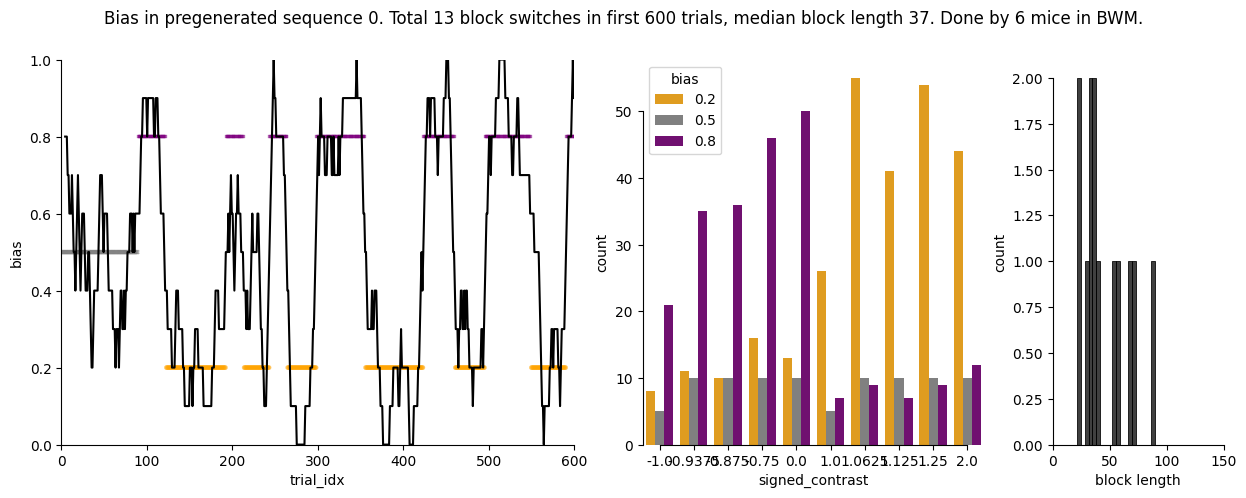

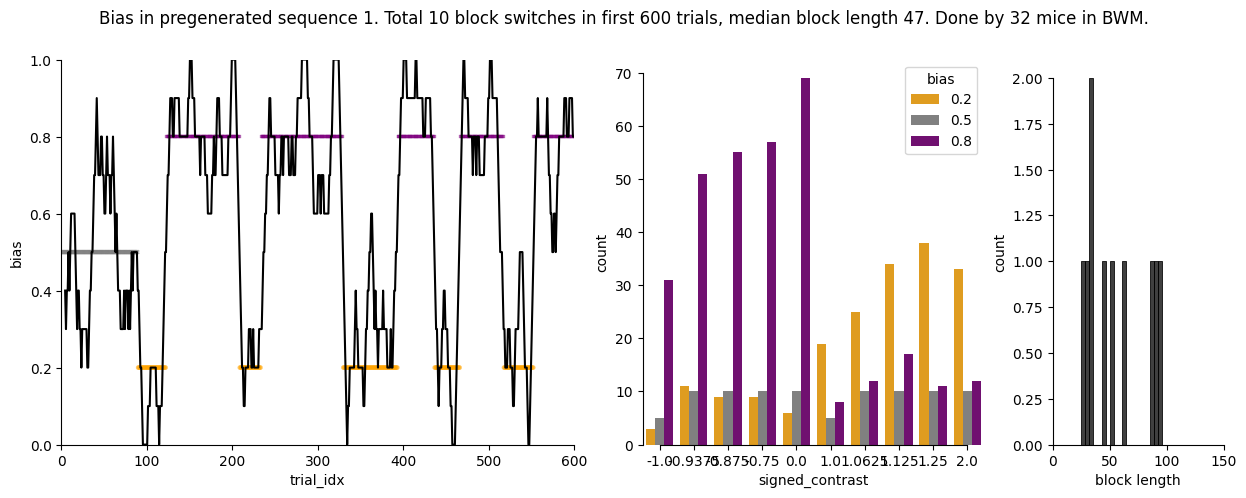

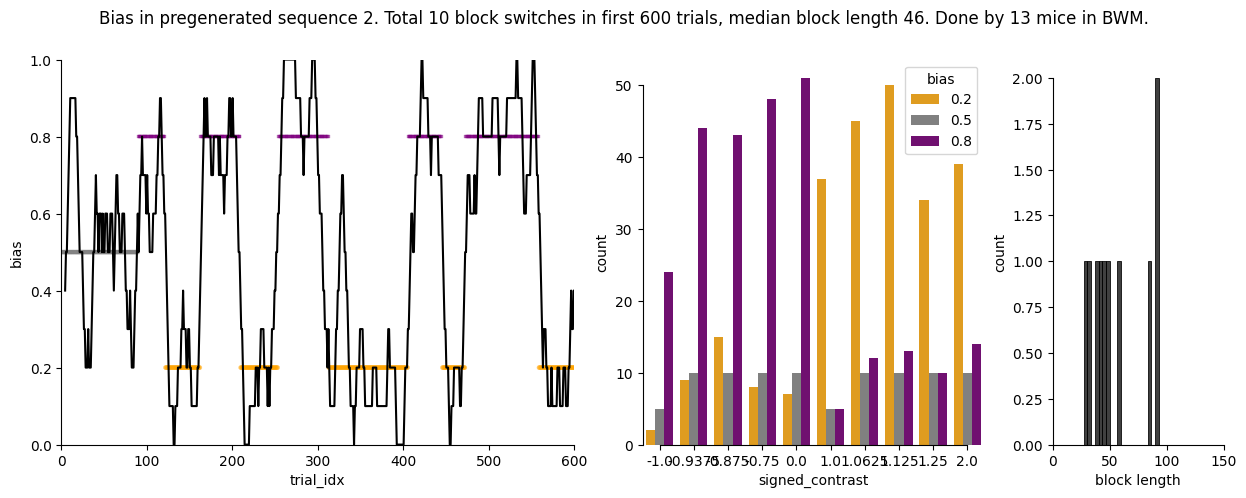

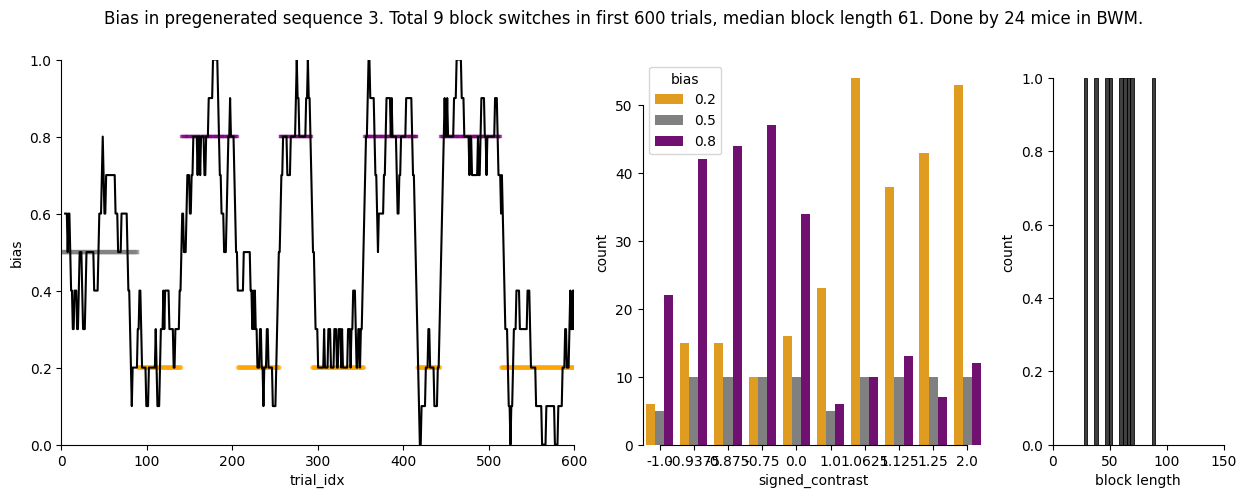

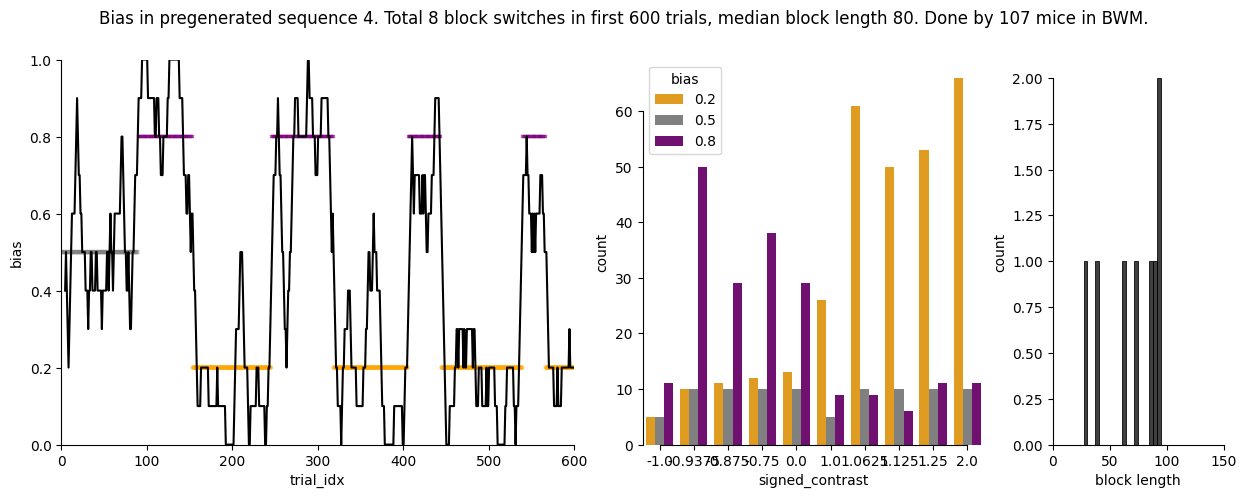

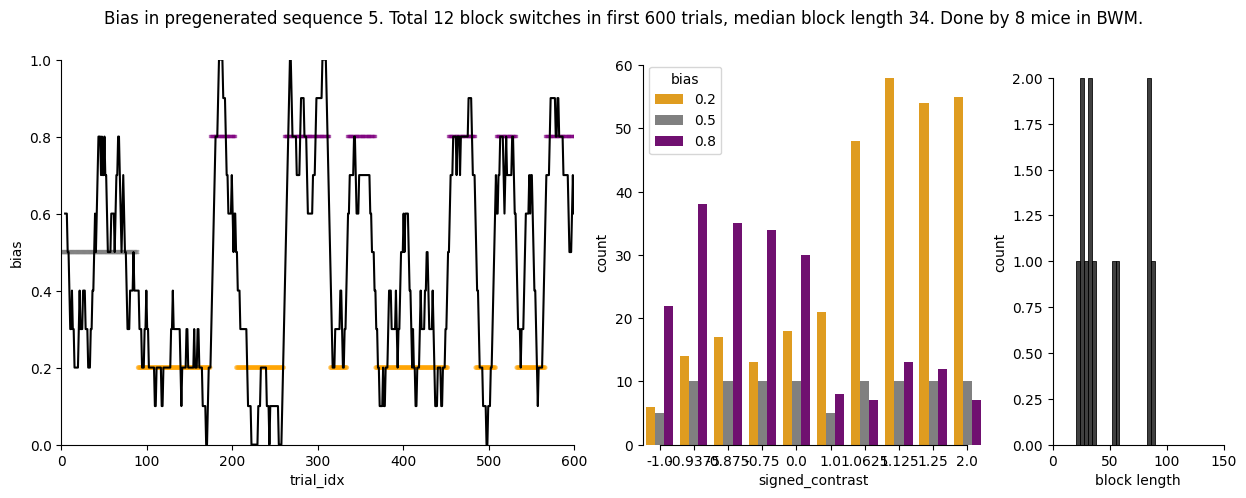

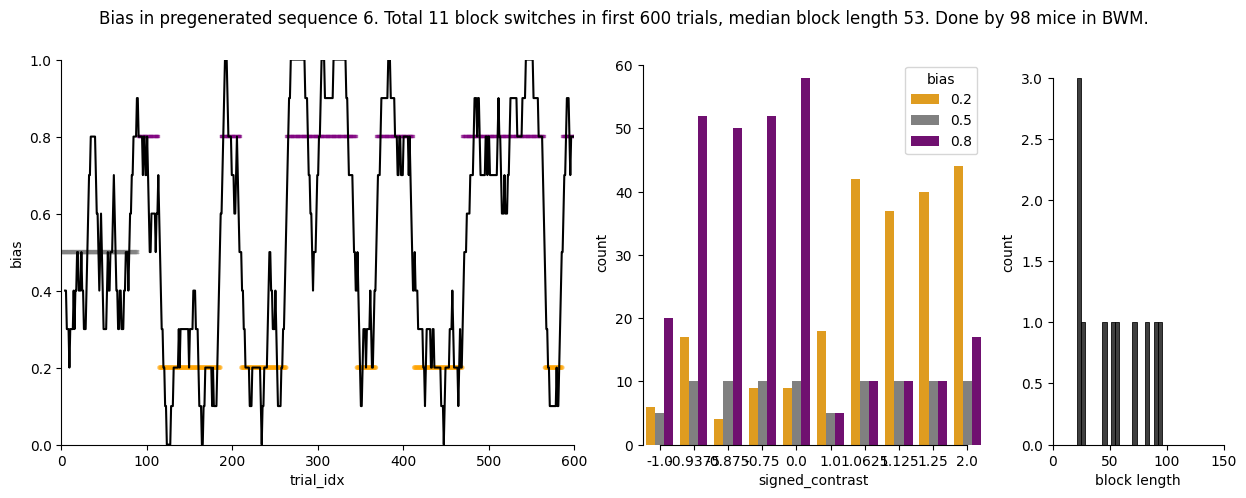

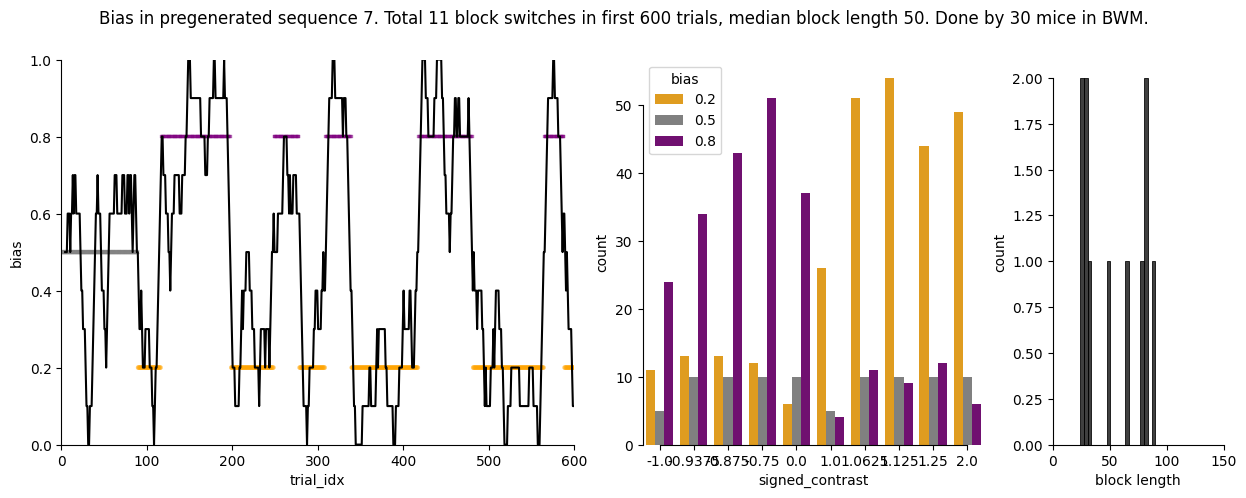

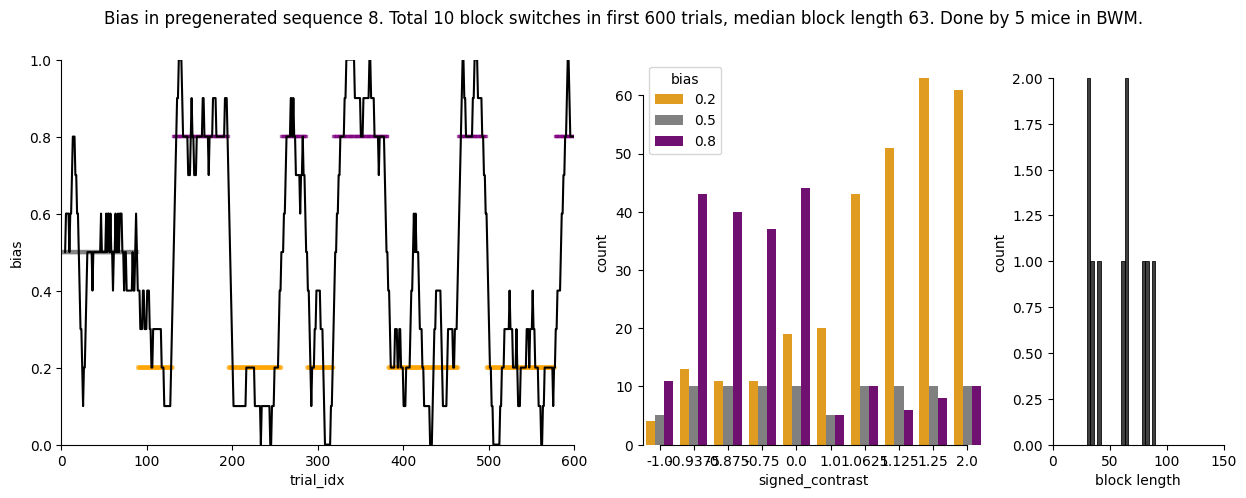

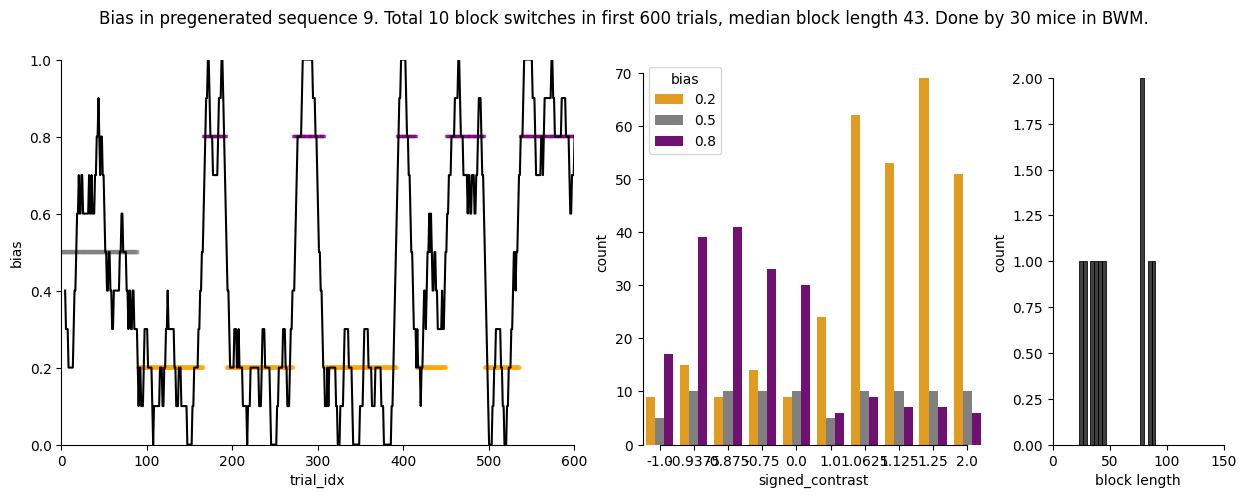

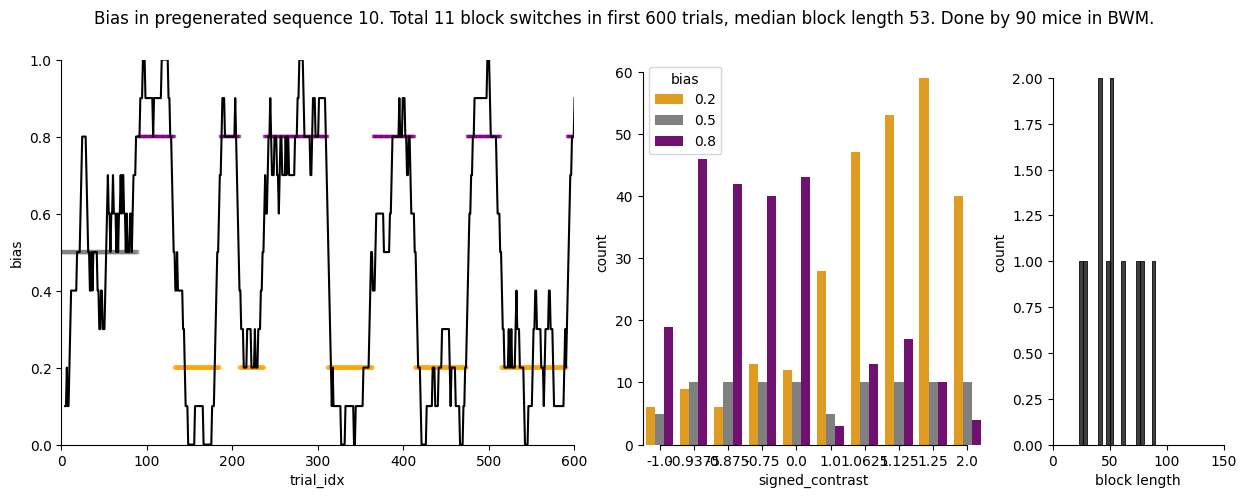

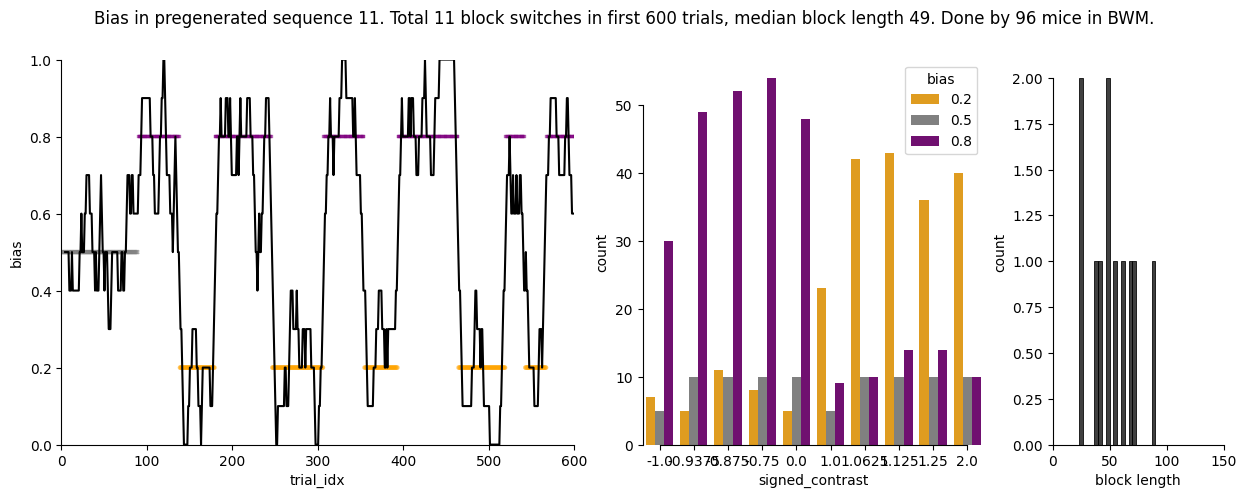

In [91]:
### now do some plotting
plt.close('all')
for i in range(12):
    df = pd.read_excel("%s/pregen_all/pregen_session_%d.xlsx" %(cwd,i))
    df['trial_idx'] = np.arange(len(df))
    df['stimSide'] = df['eccentricity'] < 0
    len_blocks = np.load("%s/raws/session_%d_ephys_len_blocks.npy" %(cwd,i))   

    fig, ax = plt.subplots(1,3,figsize=(15, 5), width_ratios=[3, 2, 1])

    # biased blocks
    sns.scatterplot(data=df, ax=ax[0], 
                    x='trial_idx', y='bias', 
                    style='bias', hue='bias',
                    palette={0.2: 'orange', 0.5:'grey', 0.8:'purple'}, 
                    marker='o', s=10, edgecolors='face',
                    alpha=.5, legend=False)
    # running median overlaid
    sns.lineplot(data=df[['trial_idx', 'stimSide']].rolling(10).mean(), 
                    ax=ax[0],
                    x='trial_idx', y='stimSide', color='black', errorbar=None)
    ax[0].set(xlim=(0, 600), ylim=(0, 1))

    # statistics in the first 600 trials
    df['signed_contrast'] = df['og_contrast'] + np.sign(df['og_eccentricity'])
    sns.countplot(data=df.iloc[:600], x='signed_contrast', hue='bias', 
                 palette={0.2: 'orange', 0.5:'grey', 0.8:'purple'}, ax=ax[1])
    
    # distribution of block lengths
    total_len_blocks = np.cumsum(len_blocks)
    sns.histplot(len_blocks[total_len_blocks < 600], ax=ax[2], bins=20, color='black')
    ax[2].set(xlabel='block length', ylabel='count', xlim=(0, 150))

    n_block_switch = np.sum(np.abs(np.diff(df['bias'][:600])) > 0)
    BWM_counts = [6, 32, 13, 24, 107, 8, 98, 30, 5, 30, 90, 96] # according to Sebastian

    sns.despine(trim=True)
    fig.suptitle('Bias in pregenerated sequence %d. Total %d block switches in first 600 trials, '%(i, n_block_switch) +
                 'median block length %2.f. Done by %d mice in BWM.'%(np.median(len_blocks[total_len_blocks < 600]), BWM_counts[i]))
    plt.savefig("%s/pregen_all/pregen_session_%d.png" %(cwd,i))

In [92]:
### now decide which ones we want to keep
keep_session_nrs = [0, 2, 3, 4, 6, 7, 8, 9, 10, 11]
for i, sess_nr in enumerate(keep_session_nrs):
    df = pd.read_excel("%s/pregen_all/pregen_session_%d.xlsx" %(cwd,sess_nr))
    df.to_excel("%s/pregen_to_use/pregen_sequence_%d.xlsx" %(cwd,i), index=False)

AttributeError: module 'os' has no attribute 'copy'